In [61]:
###print graph
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import re
#set working directory

home = os.environ["HOME"]

os.chdir(f"{home}/tiniMLVM")

folder_data = "./experiments/data_test2/"


## read controller experiment logs

#delete lines non starting with a number
with open(f"{folder_data}experiment_logs.csv", "r") as f:
    text = f.read()

text = re.sub(r"^[^0-9].*\n", "", text, flags=re.MULTILINE)

#write the text back to the file
with open(f"{folder_data}experiment_logs.csv", "w") as f:
    f.write(text)

df_controller = pd.read_csv(
    f"{folder_data}experiment_logs.csv", names=["timestamp", "log"],dtype={"timestamp": int, "log": str}
).dropna()

## read drift deploy logs

# get drift-deploy log file names

log_files = os.listdir(folder_data)

# read drift-deploy logs
df_drift_deploy = pd.DataFrame()

for log_file in log_files:
    if log_file.startswith("drift-deploy"):
        #get string text
        with open(f"{folder_data}{log_file}", "r") as f:
            text = f.read()

        #if there is only one comma in a line delete the \n

        text = re.sub(r"(^[^,]*,[^,]*[^e])\n", r"\1", text, flags=re.MULTILINE)
        text = re.sub(r"(^[^,]*,[^,]*[^e])\n", r"\1", text, flags=re.MULTILINE)
        
        #delete all the double spaces
        text = re.sub(r"  ", " ", text, flags=re.MULTILINE)
        #delete space before end of the list
        text = re.sub(r" ]", "]", text, flags=re.MULTILINE)
        text = re.sub(r"  ", " ", text, flags=re.MULTILINE)
        

        #write the text back to the file
        with open(f"{folder_data}{log_file}", "w") as f:
            f.write(text)
        
        df = pd.read_csv(
            f"{folder_data}{log_file}",dtype={"timestamp": int, "p_value": str, "drift": bool}
        )
        df_drift_deploy = pd.concat([df_drift_deploy, df])

### for each list in p_value column convert to list and get max value
df_drift_deploy['p_value'] = df_drift_deploy['p_value'].apply(lambda x: max([float(i) for i in x[1:-1].split(' ')]))

df_inference_deploy = pd.DataFrame()
#read python-tflite-deploy logs
for log_file in log_files:
    if log_file.startswith("python-tflite-deploy"):
        #get string text
        with open(f"{folder_data}{log_file}", "r") as f:
            text = f.read()

        #delete the first line with INFO
        text = re.sub(r"INFO.*\n", "", text, flags=re.MULTILINE)


        #write the text back to the file
        with open(f"{folder_data}{log_file}", "w") as f:
            f.write(text)
        
        df = pd.read_csv(
            f"{folder_data}{log_file}",names = ["timestamp","log"],dtype={"timestamp": int, "log": str}
        )
        df_inference_deploy = pd.concat([df_inference_deploy, df])

for log_file in log_files:
    if log_file.startswith("converting-job"):
        #get string text
        with open(f"{folder_data}{log_file}", "r") as f:
            text = f.read()

        #save lines with regex "^\d*,.*"
        logs = re.findall(r"^\d*,.*", text, flags=re.MULTILINE)

        #write the text back to the file
        with open(f"{folder_data}{log_file}", "w") as f:
            f.write("\n".join(logs))

        df_converting = pd.read_csv(
            f"{folder_data}{log_file}",names = ["timestamp","log"],dtype={"timestamp": int, "log": str}
        )
    
    if log_file.startswith("training-job"):
        #get string text
        with open(f"{folder_data}{log_file}", "r") as f:
            text = f.read()

        #save lines with regex "^\d*,.*"
        logs = re.findall(r"^\d*,.*", text, flags=re.MULTILINE)

        #write the text back to the file
        with open(f"{folder_data}{log_file}", "w") as f:
            f.write("\n".join(logs))

        df_training = pd.read_csv(
            f"{folder_data}{log_file}",names = ["timestamp","log"],dtype={"timestamp": int, "log": str}
        )


#subtract to all timestamps the first timestamp
first_timestamp = df_controller['timestamp'].iloc[0]


df_controller['timestamp'] = (df_controller['timestamp'] - first_timestamp)*1e-9
df_drift_deploy['timestamp'] = (df_drift_deploy['timestamp'] - first_timestamp)*1e-9
df_inference_deploy['timestamp'] = (df_inference_deploy['timestamp'] - first_timestamp)*1e-9
df_training['timestamp'] = (df_training['timestamp'] - first_timestamp)*1e-9
df_converting['timestamp'] = (df_converting['timestamp'] - first_timestamp)*1e-9



In [42]:
###get data from drift_detection_logs

#read file and delete lines not starting with a number
with open(f"{folder_data}drift_detection_logs.log", "r") as f:
    text = f.read()

text = re.sub(r"^[^0-9].*\n", "", text, flags=re.MULTILINE)


#delete INFO lines

text = re.sub(r"^.*INFO.*\n", "", text, flags=re.MULTILINE)

#write the text back to the file

with open(f"{folder_data}drift_detection_logs_refined.log", "w") as f:
    f.write(text)

df_drift_detection = pd.read_csv(
    f"{folder_data}drift_detection_logs_refined.log", names=["timestamp", "level","type" ,"log","something"],sep="\t"
)

#convert 2024-09-17T13:14:31Z to nanoseconds
df_drift_detection["timestamp"] = (pd.to_datetime(df_drift_detection["timestamp"]).astype(int) - first_timestamp)*1e-9

#drop nefative timestamps
df_drift_detection = df_drift_detection[df_drift_detection["timestamp"] > 0]


###find interesting points 

interesting_points = []

#find timestamp of log "Start training job"
start_training = df_drift_detection[df_drift_detection["log"].str.contains("Start training job")]["timestamp"].iloc[0]

interesting_points.append((start_training, "Start training job"))

#find timestamp of log "conversion job created"

conversion_job_created = df_drift_detection[df_drift_detection["log"].str.contains("conversion job created")]["timestamp"].iloc[0]

interesting_points.append((conversion_job_created, "start conversion job"))

#find timestamp of log "conversion job completed"

conversion_job_completed = df_drift_detection[df_drift_detection["log"].str.contains("Conversion job completed")]["timestamp"].iloc[0]

interesting_points.append((conversion_job_completed, "conversion job completed"))

# #find timestamp of log "Deployment restarted"

# deployment_restarted = df_drift_detection[df_drift_detection["log"].str.contains("Deployment restarted")]["timestamp"].iloc[0]

# interesting_points.append((deployment_restarted, "Deployment restarted"))


print(interesting_points)





[(np.float64(300.25564133), 'Start training job'), (np.float64(420.25564133), 'start conversion job'), (np.float64(481.25564133), 'conversion job completed')]


Text(0, 0.5, 'P-value')

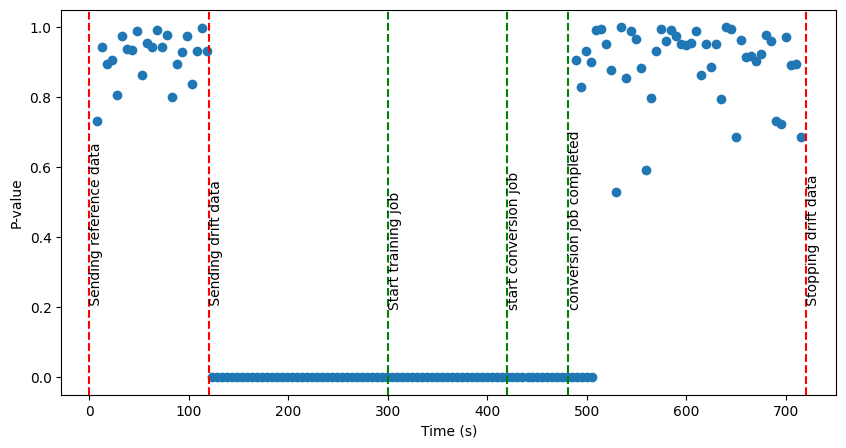

In [43]:
fig = plt.figure(figsize=(10, 5))

ax = fig.gca()

plt.scatter(df_drift_deploy["timestamp"], df_drift_deploy["p_value"], label="Drift Deploy")

for index, row in df_controller.iterrows():
    #if operator is not present in log
    if "operator" not in row["log"] and "Stopping reference data" not in row["log"]:
        ax.axvline(row["timestamp"], color="red", linestyle="--", label="Controller")
        ax.text(row["timestamp"], 0.2, row["log"], rotation=90)

for point in interesting_points:
    ax.axvline(point[0], color="green", linestyle="--", label=point[1])
    ax.text(point[0], 0.2, point[1], rotation=90)

#set axis names
plt.xlabel("Time (s)")
plt.ylabel("P-value")



Text(0, 0.5, 'Time (s)')

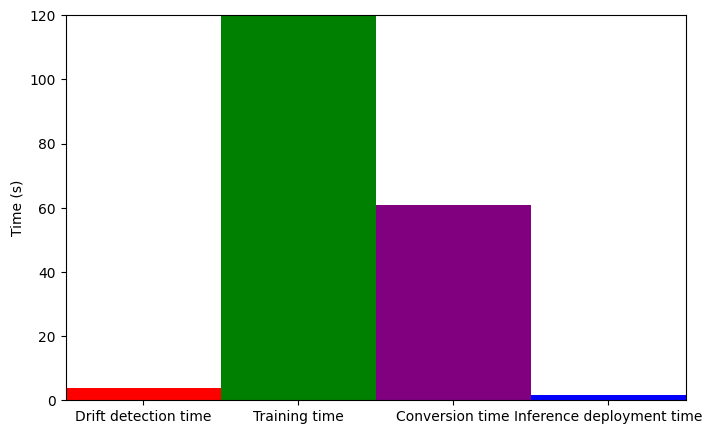

In [45]:
#bar graph with different segments

# 1) drift detection time
# 2) training time
# 3) conversion time
# 4) inference deployment time


sending_drift_data = df_controller[df_controller["log"].str.contains("Sending drift data")]["timestamp"].iloc[0]

drift_detected = min(df_drift_deploy[df_drift_deploy["drift"] == True]["timestamp"])

drift_detection_time = drift_detected - sending_drift_data

training_time = df_training[df_training["log"].str.contains("Training finished")]["timestamp"].iloc[0] - start_training

conversion_time = df_converting[df_converting["log"].str.contains("converted to tflite")]["timestamp"].iloc[0] - conversion_job_created

inference_deploy_time = max(df_inference_deploy[df_inference_deploy["log"].str.contains("starting inference")]["timestamp"]) - conversion_job_completed



fig = plt.figure(figsize=(8, 5))
ax = fig.gca()

width = 1
ax.bar("Drift detection time", drift_detection_time, color="red",align="center",width=width)
ax.bar("Training time", training_time, color="green",align="center",width=width)
ax.bar("Conversion time", conversion_time, color="purple",align="center",width=width)
ax.bar("Inference deployment time", inference_deploy_time, color="blue",align="center",width=width)

ax.margins(0)

plt.ylabel("Time (s)")

